# Amazon delta

Scene of the many channels around the Amazon river delta in northern Brazil. Landsat scene is 232/056 from 2015/10/04.

In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import xlandsat as xls
import skimage.io 

## Load the data

Use xlansat to load the L2 scene and the panchromatic band. The data were cropped to a smaller region and exported to the files we're reading below.

This is the code used to crop the original scenes:
```python
region = (510000, 610000, -76000, -18000)
# tar file downloaded from EarthExplorer
scene = xls.load_scene("LC08_L2SP_225060_20200728_20200908_02_T1.tar", bands="red green blue".split(), region=region)
# L1 band 8 and MTL.txt file downloaded individually and placed in this folder
pan = xls.load_panchromatic("LC08_L1TP_225060_20200728_20200908_02_T1/", region=region)
plt.figure(figsize=(16, 9))
xls.composite(scene, rescale_to=(0.01, 0.27)).plot.imshow()
plt.axis("scaled")
plt.show()
xls.save_scene(f"../data/amazon-delta/{scene.attrs['landsat_product_id']}.tar.gz", scene)
xls.save_scene(f"../data/amazon-delta/{pan.attrs['landsat_product_id']}.tar.gz", pan.to_dataset(promote_attrs=True))
```

In [2]:
scene = xls.load_scene("../data/amazon-delta/LC08_L2SP_225060_20200728_20200908_02_T1.tar.gz")
pan = xls.load_panchromatic("../data/amazon-delta/LC08_L1TP_225060_20200728_20200908_02_T1.tar.gz")
scene

<xarray.Dataset>
Dimensions:   (easting: 3334, northing: 1935)
Coordinates:
  * easting   (easting) float64 5.1e+05 5.1e+05 5.101e+05 ... 6.1e+05 6.1e+05
  * northing  (northing) float64 -7.602e+04 -7.599e+04 ... -1.803e+04 -1.8e+04
Data variables:
    blue      (northing, easting) float16 0.05872 0.05835 ... 0.05676 0.05713
    green     (northing, easting) float16 0.07629 0.07642 ... 0.0752 0.07434
    red       (northing, easting) float16 0.06348 0.06274 ... 0.06177 0.06116
Attributes: (12/19)
    Conventions:                CF-1.8
    title:                      Landsat 8 scene from 2020-07-28 (path/row=225...
    digital_object_identifier:  https://doi.org/10.5066/P9OGBGM6
    origin:                     Image courtesy of the U.S. Geological Survey
    landsat_product_id:         LC08_L2SP_225060_20200728_20200908_02_T1
    processing_level:           L2SP
    ...                         ...
    ellipsoid:                  WGS84
    date_acquired:              2020-07-28
    scene_center_time:          13:34:59.6026530Z
    wrs_path:                   225
    wrs_row:                    60
    mtl_file:                   GROUP = LANDSAT_METADATA_FILE\n  GROUP = PROD...

## Process

Fill any missing data gaps by interpolation and pan-sharpen the scene.

In [3]:
scene = xls.interpolate_missing(scene)
scene = xls.pansharpen(scene, pan)
scene

<xarray.Dataset>
Dimensions:   (northing: 3868, easting: 6667)
Coordinates:
  * northing  (northing) float64 -7.6e+04 -7.599e+04 ... -1.802e+04 -1.8e+04
  * easting   (easting) float64 5.1e+05 5.1e+05 5.1e+05 ... 6.1e+05 6.1e+05
Data variables:
    red       (northing, easting) float32 0.04698 0.04131 ... 0.04326 0.04502
    green     (northing, easting) float32 0.05647 0.04965 ... 0.05267 0.05473
    blue      (northing, easting) float32 0.04346 0.03821 ... 0.03976 0.04206
Attributes: (12/21)
    Conventions:                  CF-1.8
    title:                        Pansharpend Landsat 8 scene from 2020-07-28...
    digital_object_identifier:    https://doi.org/10.5066/P9OGBGM6
    origin:                       Image courtesy of the U.S. Geological Survey
    landsat_product_id:           LC08_L2SP_225060_20200728_20200908_02_T1
    processing_level:             L2SP
    ...                           ...
    scene_center_time:            13:34:59.6026530Z
    wrs_path:                     225
    wrs_row:                      60
    pansharpening_method:         Weighted Brovey Transform
    pansharpening_rgb_weights:    (1, 1, 0.2)
    pansharpening_band_filename:  LC08_L1TP_225060_20200728_20200908_02_T1_B8...

## Make the figure

Create a composite and make it look nice. Save to a temporary image file first since it's hard to get matplotlib to remove all empty borders and create an image that's exactly 3840 x 2160 pixels in size (4k).

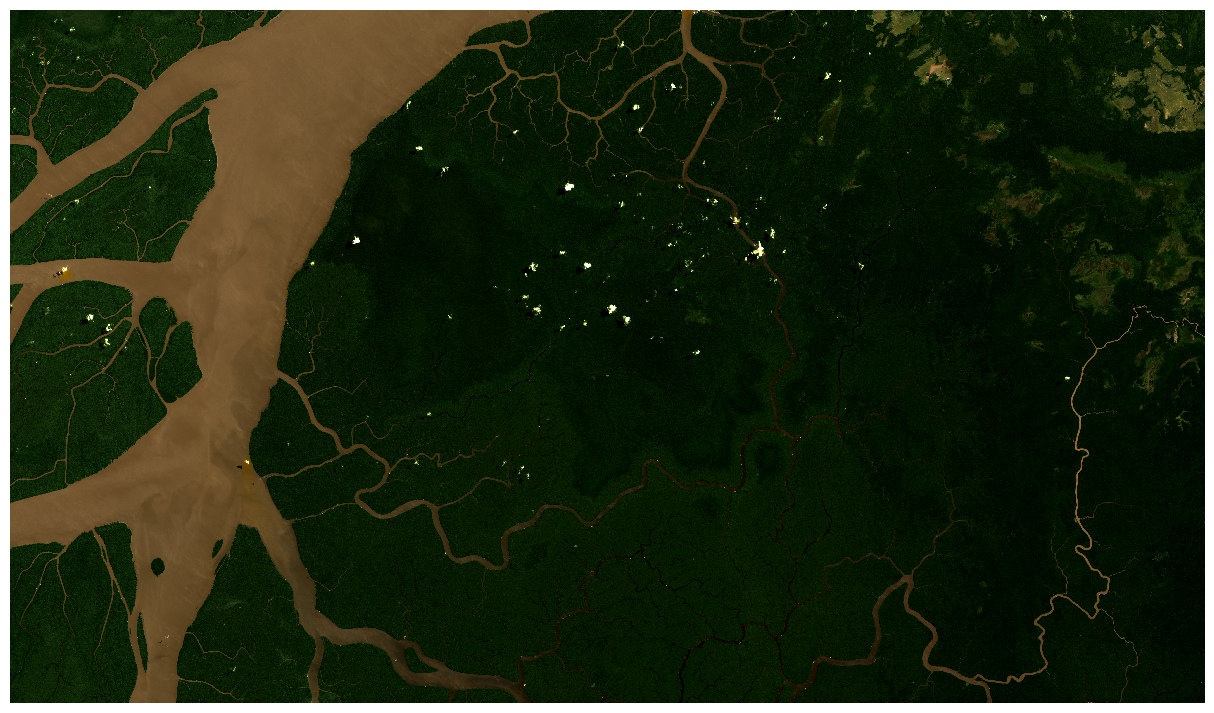

In [4]:
rgb = xls.composite(scene, rescale_to=(0.04, 0.15))

plt.figure(figsize=(16, 9))
rgb.plot.imshow()
plt.axis("scaled")
plt.axis("off")

tmp = tempfile.NamedTemporaryFile(suffix=".jpg", delete=False)
# Make sure we can read and write to this file. Windows won't allow it with open files.
tmp.close()
plt.savefig(tmp.name, dpi=330, bbox_inches="tight")

plt.show()

## Make the wallpaper

Read back the image and make sure it's exactly 4k.

In [5]:
image_larger = skimage.io.imread(tmp.name)
image_larger.shape

(2352, 4007, 3)

Crop to the exact pixel count.

In [6]:
x_offset = int((image_larger.shape[1] - 3840) // 2)
y_offset = int((image_larger.shape[0] - 2160) // 2)
image = image_larger[y_offset:2160 + y_offset, x_offset:3840 + x_offset, :]
assert image.shape == (2160, 3840, 3)

Plot it to make sure it's what we expect.

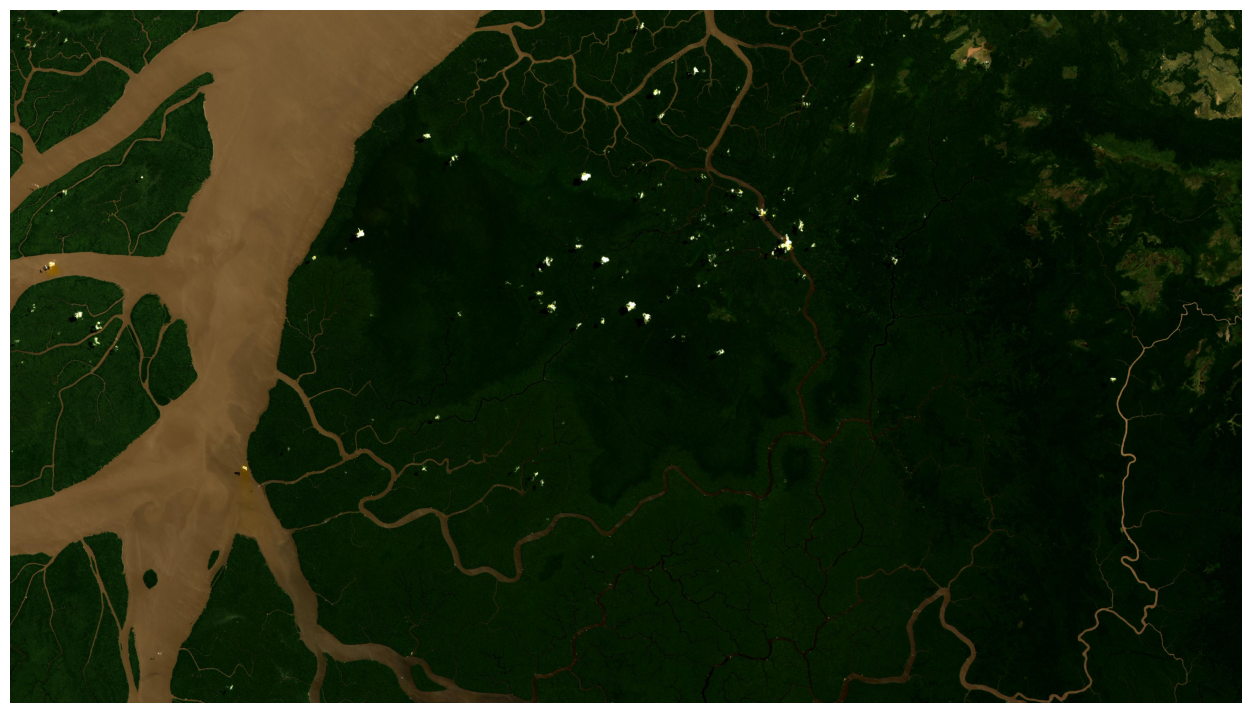

In [7]:
plt.figure(figsize=(16, 9))
plt.imshow(image)
plt.axis("scaled")
plt.axis("off")
plt.show()

Save it to the `wallpapers` folder.

In [8]:
skimage.io.imsave("../wallpapers/amazon-delta.jpg", image, quality=100)

Clean up the temporary file.

In [9]:
os.remove(tmp.name)